In [43]:
!pip install qiskit scipy pylatexenc matplotlib

# VQLS with Qiskit
**Course**: Applied Quantum Algorithms

**Date**: April 20, 2022

In this notebook, we will solve a linear system of the form
$$
A|x\rangle = |b\rangle
$$
by implementing the VQLS algorithm in Qiskit.

We will first build some of the functions ourselves and verify them, but then use the compact libraries of Qiskit to build the final version of the cost function for optimization.

In [1]:
import numpy as np
import scipy
from qiskit import Aer
from qiskit.circuit.library.n_local import TwoLocal
from qiskit.opflow import (Z, I, H, CircuitStateFn, StateFn)
from qiskit.quantum_info import Statevector

## Ansatz

First off, we know that all hybrid variational algorithms use a parametrized quantum circuit $U(\theta)$ to represent the tentative solution as

$$
|\psi(\theta)\rangle = U(\theta) |0\rangle^{\otimes n},
$$

where $N$ is the dimension of our linear system and $n=\log_2 N$.

For this exercise, we want to build the following ansatz on 3 qubits

![ansatz](https://github.com/debrevitatevitae/LabSessionsVqls/blob/main/ansatz.png?raw=1)

Notice that the CZ-gates are arranged with a *full-entanglement* logic, so controls and targets are respectively:
1. 0 -> 1
2. 0 -> 2
3. 1 -> 2

In [2]:
from qiskit import QuantumCircuit

def build_ansatz(params):
    """
    Returns the ansatz circuit for representing |\psi(\theta)>
    
    Arguments:
        params: np.ndarray containing the parameters of the rotation gates
    """
    qc = QuantumCircuit(3)
    
    # ===============
    # YOUR CODE BELOW
    # ===============
    # first ry block
    qc.ry(params[0], 0)
    qc.ry(params[1], 1)
    qc.ry(params[2], 2)
    
    # entangling block
    qc.cz(0, 1)
    qc.cz(0, 2)
    qc.cz(1, 2)
    
    # second ry block
    qc.ry(params[3], 0)
    qc.ry(params[4], 1)
    qc.ry(params[5], 2)
    
    return qc

Let's check our implementation using some random parameters as argument to our function

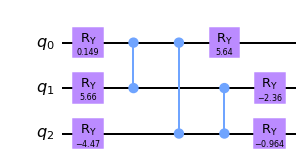

In [3]:
rng = np.random.default_rng(1)

theta_0 = rng.uniform(-2 * np.pi, 2 * np.pi, size=6)

ansatz = build_ansatz(theta_0)

ansatz.draw(output='mpl')

Instead of creating parametrized circuits yourself, Qiskit offers a set of ansatz templates that you can directly use. For instance, we can use the `TwoLocal` class to produce the same ansatz that we just created

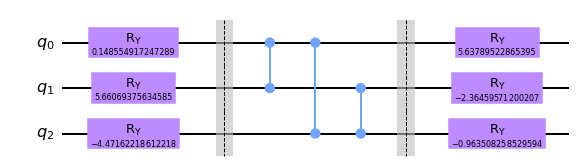

In [27]:
ansatz = TwoLocal(3, 'ry', 'cz', 'full', reps=1, insert_barriers=True)
qc = ansatz.assign_parameters(theta_0).decompose()
qc.draw(output='mpl')

## Expectation value

Let's assume that our problem is the following:

Find $|x\rangle$, such that $A|x\rangle=|b\rangle$, where

$$
A = 0.55 I + 0.225 Z_1 + 0.225 Z_2
$$

and

$$
|b\rangle = B |0\rangle^{\otimes 3} = H^{\otimes 3} |0\rangle^{\otimes 3}.
$$

We know that a possible cost function used in VQLS is

$$
C(\theta) = \langle\psi(\theta)| A^\dagger (I - |b\rangle\langle b|) A |\psi(\theta)\rangle,
$$

which we can also write as

$$
C(\theta) = \langle\psi(\theta)| A^\dagger A |\psi(\theta)\rangle - \langle\psi(\theta)| A^\dagger B |0\rangle\langle 0 | B^\dagger A |\psi(\theta)\rangle.
$$

## Exercise
Write your own code to calculate the expactation value of the observable:
$$
obs = Z \otimes Z \otimes I.
$$
To do this use: 
$$
\begin{align}
\langle Z \rangle &=\langle q | Z | q\rangle =\langle q|0\rangle\langle 0|q\rangle - \langle q|1\rangle\langle 1|q\rangle
=|\langle 0 |q\rangle|^2 - |\langle 1 | q\rangle|^2,\\\\
\end{align}
$$
and so now we get:
$$
\begin{align}
\langle obs \rangle &
=|\langle 0 0 0 |q\rangle|^2 +|\langle 0 0 1 | q\rangle|^2 + |\langle 1 1 0 |q\rangle|^2 + |\langle 1 1 1 | q\rangle|^2 -|\langle 0 1 0 |q\rangle|^2 - |\langle 0 1 1 | q\rangle|^2 - |\langle 1 0 0 |q\rangle|^2 - |\langle 1 0 1 | q\rangle|^2.\\\\
\end{align}
$$

In [5]:
backend = Aer.get_backend('statevector_simulator')

In [6]:
obs = Z ^ Z ^ I

In [7]:
psi = CircuitStateFn(ansatz.assign_parameters(theta_0))


In [12]:
psi_sampled = psi.sample()

In [13]:
def expectation_value(psi_sample):
    ## your code here ## 

    positive = psi_sample['000'] + psi_sample['001'] + psi_sample['110']\
      + psi_sample['111']
    negative = psi_sample['010'] + psi_sample['011'] + psi_sample['101']\
      + psi_sample['100']
      
    return positive - negative

In [14]:
ev = expectation_value(psi_sampled)

Now we test if our created expectation value was correct by comparing it to the qiskit pre-implemented version. 

In [15]:
ev_qiskit = StateFn(obs).adjoint().eval(psi)

In [16]:
ev_qiskit - ev

(-0.02872603722658007+0j)

### Better expectation values

In [28]:
A = 0.55 * (I ^ I ^ I) \
    + 0.225 * (I ^ Z ^ I) \
        + 0.225 * (I ^ I ^ Z)

B = (H ^ H ^ H).to_pauli_op()

In [29]:
A_squared = (~A) @ A

In [30]:
zero_proj = 0.5 * (I + Z)
zero_proj_3 = zero_proj ^ zero_proj ^ zero_proj

In [31]:
print(zero_proj_3.to_matrix())

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [32]:
A_b_proj = (~A) @ (~B) @ zero_proj_3 @ B @ A

In [33]:
ev1 = StateFn(A_squared).adjoint().eval(psi)
ev2 = StateFn(A_b_proj).adjoint().eval(psi)
print(ev1.real)
print(ev2.real)

0.4386019602938086
0.000220080079551968


In [37]:
def cost(params):
    """
    Returns the global un-normalized cost function for VQLS:
    C_G = <\psi| (~A (1-|b><b|) A) |\psi>
    """

    # ===============
    # YOUR CODE BELOW
    # ===============
    
    psi = CircuitStateFn(ansatz.assign_parameters(params))
    
    ev1 = StateFn(A_squared).adjoint().eval(psi)
    ev2 = StateFn(A_b_proj).adjoint().eval(psi)

    cost_eval = 1 - ev2 / ev1

    return cost_eval

In [38]:
out = scipy.optimize.minimize(cost, x0=theta_0, method="COBYLA", options={'maxiter':500})
print(out)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/cobyla.py:262: ComplexWarning: Casting complex values to real discards the imaginary part
  dinfo=info)


     fun: 1.8286908964881832e-07
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 184
  status: 1
 success: True
       x: array([-0.16048891,  7.17505604, -3.14139321,  8.93949503, -2.64005941,
       -1.56993953])


In [39]:
theta_opt = out.x
zero_state = Statevector.from_label('000')
psi_opt = zero_state.evolve(ansatz.assign_parameters(theta_opt))
psi_opt_vector = psi_opt.data
print(psi_opt_vector)

[0.06812859+0.j 0.12393742+0.j 0.12386318+0.j 0.68129708+0.j
 0.06816744+0.j 0.12395552+0.j 0.12400603+0.j 0.6819831 +0.j]


In [40]:
x_true = np.linalg.solve(A.to_matrix(), (1/np.sqrt(8) * np.ones(8)))
x_true_norm = np.linalg.norm(x_true)
print(x_true / x_true_norm)

[0.06816407+0.j 0.12393467+0.j 0.12393467+0.j 0.68164071+0.j
 0.06816407+0.j 0.12393467+0.j 0.12393467+0.j 0.68164071+0.j]
